In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
%matplotlib inline

spark = SparkSession.builder.appName('unsupervised').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '8g'), ('spark.app.name', 'Spark Updated Conf'),\
                                        ('spark.executor.cores', '8'), ('spark.cores.max', '8'), ('spark.driver.memory','8g')])

spark.sparkContext.getConf().getAll()

[('spark.app.startTime', '1700871052401'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-9999.0-empty-to-avoid-con

In [2]:
# read in rideshare data for all years, concatenate, create appropriate partitioning
# we are dropping 2020 because covid will affect the performance of our model

df_2018 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/program_area_time_rides_2018.csv", inferSchema=True, header=True)
df_2019 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/program_area_time_rides_2019.csv", inferSchema=True, header=True)
df_2021 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/program_area_time_rides_2021.csv", inferSchema=True, header=True)
df_2022 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/program_area_time_rides_2022.csv", inferSchema=True, header=True)
df_2023 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/program_area_time_rides_2023.csv", inferSchema=True, header=True)

# dropping new columns in 2023
df_2023 = df_2023.drop('Shared Trip Match','Percent Time Chicago','Percent Distance Chicago')

before = df_2018.union(df_2019)
after = df_2021.union(df_2022)


In [3]:
before.show(1)

+--------------------+-------------------+-------------------+-------+-----+------------+-------------+-----------+------------+----+---+-----+------------+-------------+------------+-------------+-----+------------+----+---+
|                  ID|    start_timestamp|      end_timestamp|seconds|miles|pickup_tract|dropoff_tract|pickup_area|dropoff_area|Fare|Tip|total|  pickup_lat|   pickup_lon| dropoff_lat|  dropoff_lon|month|day_of_month|hour|day|
+--------------------+-------------------+-------------------+-------+-----+------------+-------------+-----------+------------+----+---+-----+------------+-------------+------------+-------------+-----+------------+----+---+
|e516d63949ba04900...|2018-11-22 22:15:00|2018-11-22 22:15:00|    194|  0.7|        null|         null|         41|          41| 2.5|  5| 10.0|41.794090253|-87.592310855|41.794090253|-87.592310855|   11|          22|  22|  5|
+--------------------+-------------------+-------------------+-------+-----+------------+-------

In [4]:
after.show(1)

+--------------------+-------------------+-------------------+-------+-----+------------+-------------+-----------+------------+----+---+-----------------+------------+-------------+------------+-------------+-----+------------+----+---+
|                  ID|    start_timestamp|      end_timestamp|seconds|miles|pickup_tract|dropoff_tract|pickup_area|dropoff_area|Fare|Tip|            total|  pickup_lat|   pickup_lon| dropoff_lat|  dropoff_lon|month|day_of_month|hour|day|
+--------------------+-------------------+-------------------+-------+-----+------------+-------------+-----------+------------+----+---+-----------------+------------+-------------+------------+-------------+-----+------------+----+---+
|fd77b136fa1d4df45...|2021-11-16 17:45:00|2021-11-16 17:45:00|    247|  0.8|        null|         null|         41|          41| 5.0|  0|7.359999999999999|41.794090253|-87.592310855|41.794090253|-87.592310855|   11|          16|  17|  3|
+--------------------+-------------------+------

In [5]:
#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)


In [6]:
before.rdd.getNumPartitions()
displaypartitions(before)

Partitions: 31


+-----------+-----+
|partitionId|count|
+-----------+-----+
|         14| 1762|
|         13| 1907|
|         12| 1970|
|         11| 2021|
|         10| 2100|
|          9| 2182|
|          8| 2263|
|          7| 2373|
|          6| 2506|
|          5| 2695|
|         30| 3846|
|          4| 4487|
|          3| 4701|
|          2| 5057|
|          1| 5664|
|          0| 5953|
|         29| 7868|
|         28| 8062|
|         27| 8256|
|         26| 8484|
|         25| 9493|
|         24|10490|
|         23|10618|
|         22|10800|
|         21|11035|
|         20|15695|
|         19|18407|
|         18|18610|
|         17|18886|
|         16|19071|
|         15|19369|
+-----------+-----+



In [7]:
after.rdd.getNumPartitions()
displaypartitions(after)

Partitions: 32


+-----------+-----+
|partitionId|count|
+-----------+-----+
|         15|   82|
|         14|  212|
|         13|  282|
|         12|  434|
|         11|  554|
|         10|  726|
|          9|  967|
|          8| 1164|
|          7| 1944|
|          6| 2307|
|          5| 3238|
|          4| 5508|
|         31| 5795|
|          3| 5853|
|          2| 9015|
|         30|10970|
|         29|11178|
|          1|11261|
|         28|11462|
|         27|11731|
|          0|11912|
|         26|24062|
|         25|29470|
|         24|29783|
|         23|30064|
|         22|30327|
|         21|41156|
|         20|53078|
|         19|53357|
|         18|53848|
|         17|54237|
|         16|54823|
+-----------+-----+



In [3]:
before = before.repartition(50)
after = after.repartition(50)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN
from sklearn import metrics
from pyspark.sql.functions import col, radians, acos, sin, cos, lit
import time
from pyspark.ml.feature import VectorAssembler


# Feature Engineering

In [5]:
pickAssembler = VectorAssembler(inputCols=["pickup_lat", "pickup_lon"], outputCol="pickup_features")
dropAssembler = VectorAssembler(inputCols=["dropoff_lat", "dropoff_lon"], outputCol="dropoff_features")

# combining pickup and dropoff location latitudes and longitudes for before and after lyft program data
before = pickAssembler.transform(before)
before = dropAssembler.transform(before)

after = pickAssembler.transform(after)
after = dropAssembler.transform(after)


In [6]:
before.printSchema()

root
 |-- ID: string (nullable = true)
 |-- start_timestamp: timestamp (nullable = true)
 |-- end_timestamp: timestamp (nullable = true)
 |-- seconds: integer (nullable = true)
 |-- miles: double (nullable = true)
 |-- pickup_tract: long (nullable = true)
 |-- dropoff_tract: long (nullable = true)
 |-- pickup_area: integer (nullable = true)
 |-- dropoff_area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tip: integer (nullable = true)
 |-- total: double (nullable = true)
 |-- pickup_lat: double (nullable = true)
 |-- pickup_lon: double (nullable = true)
 |-- dropoff_lat: double (nullable = true)
 |-- dropoff_lon: double (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- pickup_features: vector (nullable = true)
 |-- dropoff_features: vector (nullable = true)



# Modeling

In [7]:
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col


# KMeans for pickup features
kmeans_pickup = KMeans(k=15, seed=1, featuresCol='pickup_features', predictionCol='pickup_cluster')

before = kmeans_pickup.fit(before).transform(before)

after = kmeans_pickup.fit(after).transform(after)


23/11/25 00:12:22 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/11/25 00:12:23 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [8]:
# KMeans for dropoff features
kmeans_dropoff = KMeans(k=15, seed=1, featuresCol='dropoff_features', predictionCol='dropoff_cluster')

before = kmeans_dropoff.fit(before).transform(before)

after = kmeans_dropoff.fit(after).transform(after)


In [9]:
before.select('pickup_cluster', 'dropoff_cluster').show()

+--------------+---------------+
|pickup_cluster|dropoff_cluster|
+--------------+---------------+
|             5|             13|
|             1|             14|
|             1|             13|
|             1|             13|
|             1|             13|
|             1|             13|
|             5|             13|
|             1|             11|
|             5|             14|
|             9|              6|
|            11|              4|
|            13|             10|
|            13|             10|
|             1|              7|
|             9|             14|
|             1|              4|
|             1|             10|
|             1|             10|
|             1|             10|
|            11|             13|
+--------------+---------------+
only showing top 20 rows



In [10]:
after.select('pickup_cluster', 'dropoff_cluster').show()

+--------------+---------------+
|pickup_cluster|dropoff_cluster|
+--------------+---------------+
|            11|              2|
|             5|              8|
|             5|              8|
|             5|              8|
|             5|              8|
|             0|              7|
|             5|              2|
|             5|              2|
|             5|              2|
|             5|              2|
|             5|              2|
|             5|              2|
|             5|              2|
|            11|              2|
|            11|              2|
|             0|              8|
|             5|              5|
|             5|              5|
|             0|              7|
|            11|              5|
+--------------+---------------+
only showing top 20 rows



# this piece of code was depreciated 

In [5]:
#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)

df_all.rdd.getNumPartitions()
displaypartitions(df_all)

Partitions: 534


+-----------+------+
|partitionId| count|
+-----------+------+
|         33|152646|
|        233|328837|
|        232|328975|
|        231|329131|
|        230|329163|
|        229|329209|
|        227|329245|
|        225|329263|
|        228|329263|
|        224|329311|
|        226|329315|
|        222|329332|
|        223|329344|
|        221|329373|
|        218|329389|
|        219|329390|
|        217|329399|
|        215|329410|
|        216|329410|
|        214|329418|
|        220|329427|
|        213|329428|
|        210|329461|
|        212|329481|
|        211|329505|
|        207|329507|
|        208|329513|
|        209|329519|
|        206|329523|
|        204|329533|
|        203|329555|
|        205|329574|
|        201|329587|
|        202|329591|
|        198|329607|
|        200|329623|
|        196|329624|
|        199|329630|
|        197|329633|
|        195|329646|
|        192|329654|
|        194|329673|
|        193|329678|
|        184|329704|
|        191|

In [4]:
# repartitioning to 600 partitions
df_all = df_all.repartition(600).cache()
#displaypartitions(df_all)

**Feature Engineering**


In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp

df_all = df_all.withColumn("start_timestamp", unix_timestamp("start_timestamp"))
df_all = df_all.withColumn("end_timestamp", unix_timestamp("end_timestamp"))

# Calculate trip duration in seconds
df_all = df_all.withColumn("trip_duration", col("end_timestamp") - col("start_timestamp"))

# Convert seconds to minutes
df_all = df_all.withColumn("trip_duration", col("trip_duration") / 60)

df_all.select('trip_duration').show()


+-------------+
|trip_duration|
+-------------+
|         30.0|
|         30.0|
|         30.0|
|          0.0|
|         30.0|
|         15.0|
|         15.0|
|         15.0|
|         15.0|
|         15.0|
|         15.0|
|         15.0|
|         60.0|
|         15.0|
|         45.0|
|         15.0|
|          0.0|
|         30.0|
|         15.0|
|         45.0|
+-------------+
only showing top 20 rows



In [4]:
from pyspark.sql.functions import col, unix_timestamp

df_2018 = df_2018.withColumn("start_timestamp", unix_timestamp("start_timestamp"))
df_2018 = df_2018.withColumn("end_timestamp", unix_timestamp("end_timestamp"))

# Calculate trip duration in seconds
df_2018 = df_2018.withColumn("trip_duration", col("end_timestamp") - col("start_timestamp"))

# Convert seconds to minutes
df_2018 = df_2018.withColumn("trip_duration", col("trip_duration") / 60)

df_2018.select('trip_duration').show()

+-------------+
|trip_duration|
+-------------+
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|          0.0|
|         15.0|
|         15.0|
|          0.0|
|          0.0|
|         15.0|
|          0.0|
|          0.0|
|          0.0|
+-------------+
only showing top 20 rows



In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN
from sklearn import metrics
from pyspark.sql.functions import col, radians, acos, sin, cos, lit
import time
from pyspark.ml.feature import VectorAssembler


In [7]:
df_all.printSchema()

root
 |-- ID: string (nullable = true)
 |-- start_timestamp: long (nullable = true)
 |-- end_timestamp: long (nullable = true)
 |-- seconds: integer (nullable = true)
 |-- miles: double (nullable = true)
 |-- pickup_tract: long (nullable = true)
 |-- dropoff_tract: long (nullable = true)
 |-- pickup_area: integer (nullable = true)
 |-- dropoff_area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tip: integer (nullable = true)
 |-- total: double (nullable = true)
 |-- pickup_lat: double (nullable = true)
 |-- pickup_lon: double (nullable = true)
 |-- dropoff_lat: double (nullable = true)
 |-- dropoff_lon: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- trip_duration: double (nullable = true)



In [90]:
pdf = df_2018.select('ID', 'pickup_lat','pickup_lon', 'dropoff_lat', 'dropoff_lon').toPandas()


In [91]:
# Earth's radius in kilometers
rad_in_kms = 6371
len(pdf)

15276344

In [ ]:
# Fit DBSCAN model for pickup location using scikit-learn
epsilon_pickup = 0.5 / rad_in_kms  # Earth's radius in kilometers
dbscan_pickup = DBSCAN(eps=0.006, min_samples=10, algorithm='ball_tree', metric='haversine')
pickup_features = np.array(pdf[["pickup_lon", "pickup_lat"]])
pdf["pickup_prediction"] = dbscan_pickup.fit_predict(pickup_features)

# Filter out noise points for pickup location (prediction == -1)
#pdf = pdf[pdf["pickup_prediction"] != -1]


In [62]:
# Fit DBSCAN model for dropoff location using scikit-learn
epsilon_dropoff = 1.5 / rad_in_kms  
dbscan_dropoff = DBSCAN(eps=0.03, min_samples=10, algorithm='ball_tree', metric='haversine')
dropoff_features = np.array(pdf[["dropoff_lon", "dropoff_lat"]])
pdf["dropoff_prediction"] = dbscan_dropoff.fit_predict(dropoff_features)

# Filter out noise points for dropoff location (prediction == -1)
#pdf = pdf[pdf["dropoff_prediction"] != -1]


In [80]:
len(pdf)

47641

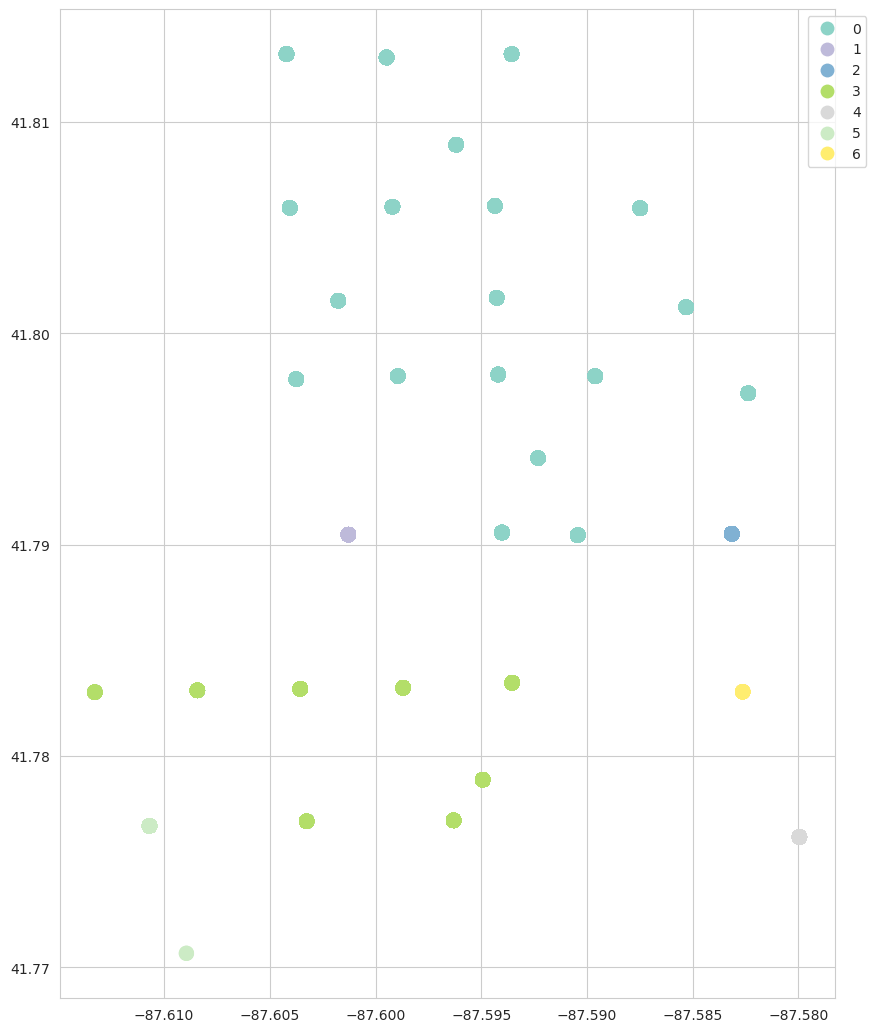

In [87]:
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(pdf['pickup_lon'], pdf['pickup_lat'])]
geo_df = gpd.GeoDataFrame(pdf, geometry=geometry)

# Plotting
fig, ax = plt.subplots(figsize=(10, 15))
geo_df.plot(ax=ax, markersize=100, column='pickup_prediction', cmap='Set3', categorical=True, legend=True)

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.05, 1))  # Adjust the values as needed

plt.show()


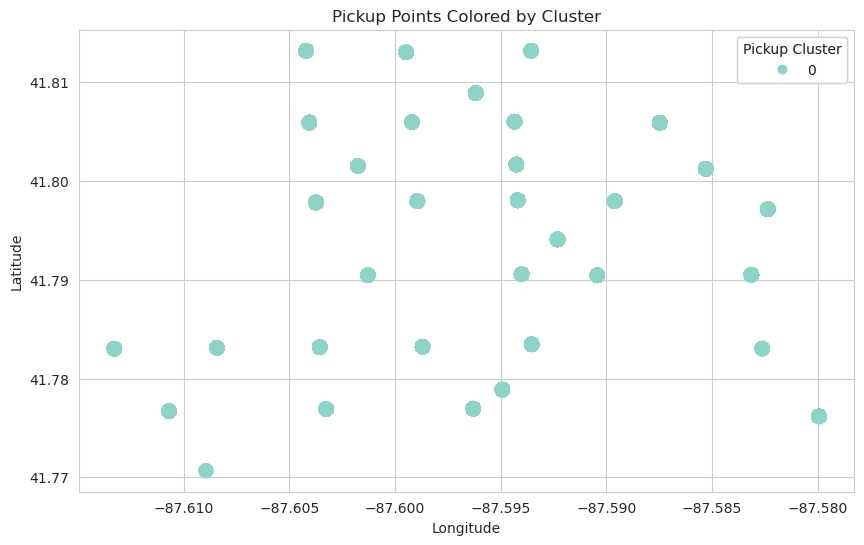

In [71]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'pd_df' with pickup cluster information
# You can replace 'pickup_longitude', 'pickup_latitude', and 'pickup_cluster' with your actual column names

plt.figure(figsize=(10, 6))

# Scatter plot colored by cluster
scatter = plt.scatter(pdf['pickup_lon'], pdf['pickup_lat'], c=pdf['pickup_prediction'], cmap='Set3', s=100)

# Add legend
legend = plt.legend(*scatter.legend_elements(), title='Pickup Cluster')
plt.gca().add_artist(legend)

plt.title('Pickup Points Colored by Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


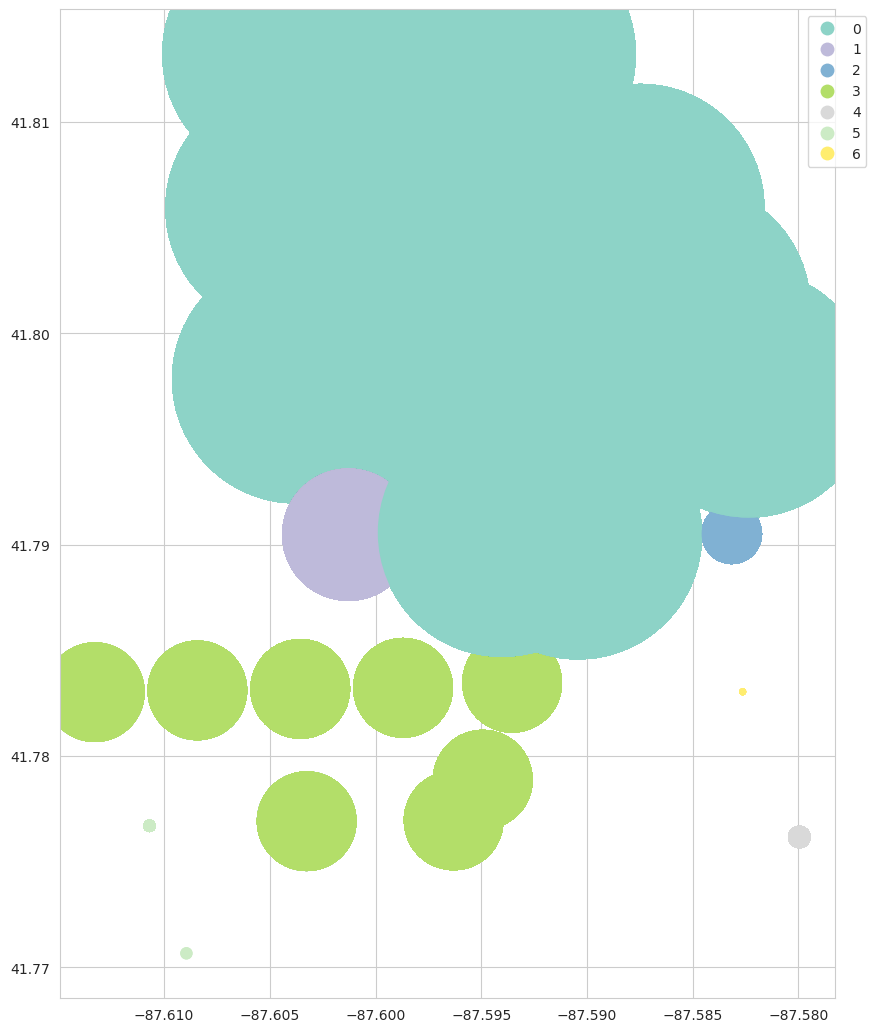

In [85]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Assuming 'pickup_prediction' is a categorical variable in your GeoDataFrame
pdf['pickup_prediction'] = pdf['pickup_prediction'].astype('category')

# Calculate the count of records for each category
category_counts = pdf['pickup_prediction'].value_counts()

# Create a dictionary mapping each category to its count
category_count_dict = dict(zip(category_counts.index, category_counts.values))

# Create a new column 'count' in the GeoDataFrame to store the count for each record's category
geo_df['count'] = geo_df['pickup_prediction'].map(category_count_dict)

# Plotting
fig, ax = plt.subplots(figsize=(10, 15))
geo_df.plot(ax=ax, markersize=geo_df['count'], column='pickup_prediction', cmap='Set3', categorical=True, legend=True)

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.05, 1))  # Adjust the values as needed

plt.show()

In [ ]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=15, seed=1) 
model = kmeans.fit(df_2018.select('features'))

### Vecorizing and getting pickup clusters
vecAssembler = VectorAssembler(inputCols=["pickup_latitude", "pickup_longitude"], outputCol="features")
new_df = vecAssembler.transform(df)
df = model.transform(new_df)

## assigniung prediction to pickup cluster
df = data1_df.withColumnRenamed('prediction', 'pickup_cluster')
df = data1_df.drop('features')

### Vecorizing and getting dropoff clusters
vecAssembler = VectorAssembler(inputCols=["dropoff_latitude", "dropoff_longitude"], outputCol="features")
new_df = vecAssembler.transform(df)
df = model.transform(new_df)

## assigniung prediction to dropoff cluster
df = data1_df.withColumnRenamed('prediction', 'dropoff_cluster')
df = data1_df.drop('features')

whether clusters have increased or decreased, distance between clusters, figure out the actual locations, put geo markers on map, closest centroid to key locations and how that changesyea

combine before and after

movement of centroids over the years

